# Capstone2 : Apparel Images

Evaluate various models and image sizes for apparel dataset:

* Specify model suffix (in **main** section)

 

        > Models are defined in **x10MakeModel** section




* Specify image size in **x000setup** section



**NOTE:**  Initial Models: 1, 2, 6 (some other were defined when having resources issues due to complexity and use of large image size(494))



# Import tf to find out version



In [0]:
import tensorflow as tf


In [3]:
print(tf.__version__)

2.2.0


In [4]:
#tf.test.gpu_device_name()

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri May 29 14:06:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Connect to Google drive


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
!ls "/content/gdrive/My Drive/Capstone2/data/"

apparelSmallTest  apparelSmallTrain  apparelSmallValidate  capstone2.ipynb


In [0]:
# https://www.avanwyk.com/finding-a-learning-rate-in-tensorflow-2/



import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.callbacks import Callback


class LRFinder(Callback):
    """Callback that exponentially adjusts the learning rate after each training batch between start_lr and
    end_lr for a maximum number of batches: max_step. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the plot method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 1e-1, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self, tail):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs[:-tail], self.losses[:-tail])


# Moving on ...done with CoLab stuf

## From x000setup.py



In [0]:
import os

import tensorflow as tf

import matplotlib.pyplot as plt
import math

 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler


## Directory Paths

In [9]:
path = "/content/gdrive/My Drive/Capstone2/data/"
srcdir = path + 'apparel-images-dataset\\'

trainingdir = path + 'apparelSmallTrain'
testdir = path + 'apparelSmallTest'
validdir = path + 'apparelSmallValidate'
print(trainingdir)

/content/gdrive/My Drive/Capstone2/data/apparelSmallTrain


In [0]:

def getHistoryPath():
    #history_path = 'C:\\Users\\rozoe\\jy\\ch10ML\\tensorflow\\capstone2\\history\\'
    history_path = "/content/gdrive/My Drive/Capstone2/history/"
    return history_path  


## Parameters

In [11]:

# =============================================================================
# inLine Parameters
# =============================================================================

num_classes = 10
num_epochs = 250
epochs = num_epochs

#batch_size for model.fit
batch_size = 32  

print(num_classes,  num_epochs, batch_size)

10 250 32


## setPixels()

In [0]:
def setPixels(img_rows, img_cols, depth=3):
    # input image dimensions
    img_rows, img_cols = 150, 150
    input_shape = (img_rows, img_cols, 3)

    target_size = input_shape[:2]
    return (input_shape, target_size)



##xOptimizer


In [0]:

def getOptimizer(optName, learning_rate, epochs):
    if optname == 'Adam':
        xoptimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    if optname == 'amsgrad':
        xoptimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=True)
        
    if optname == 'Sgd':
        momentum = 0.8
        #epochs = 250
        decay_rate = learning_rate / epochs
        xoptimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate)
    if optname =='sgdStep':
        momentum = 0.8
        xoptimizer = tf.keras.optimizers.SGD(learning_rate=0.0, momentum=momentum)
        
    return xoptimizer

 



## Callbacks


In [14]:
# =============================================================================
# Callbacks
# =============================================================================

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8,
                   restore_best_weights=True)

# drop-based learning rate
#https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/

def step_decay(epoch):
	initial_lrate = 0.0005
	drop = 0.5
	epochs_drop = 10.0
	#epochs_drop = 5.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

# learning ratee schedule callback
lrate = LearningRateScheduler(step_decay)

callbacks = [es, lrate]
callbacks = [es]

print(callbacks)
 


# Function Definitions

## Data Generators

In [0]:
def dataGenerators(target_size):
    #!!import tensorflow as tf
    import keras_preprocessing
    from keras_preprocessing import image
    from keras_preprocessing.image import ImageDataGenerator
    
    TRAINING_DIR = trainingdir
    training_datagen = ImageDataGenerator(
          rescale = 1./255,
    	  rotation_range=40,
          width_shift_range=0.2,
          height_shift_range=0.2,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True,
          fill_mode='nearest')
    
    
    VALIDATION_DIR = validdir
    validation_datagen = ImageDataGenerator(rescale = 1./255)

    
    train_generator = training_datagen.flow_from_directory(
    	TRAINING_DIR,
    	target_size=target_size,
        color_mode='rgb',
    	class_mode='categorical'
    )
    
    validation_generator = validation_datagen.flow_from_directory(
    	VALIDATION_DIR,
    	target_size=target_size,
        color_mode='rgb',
    	class_mode='categorical'
    )

    
    return train_generator, validation_generator
    


def testDataGenerator(target_size):
    #!!import tensorflow as tf
    import keras_preprocessing
    from keras_preprocessing import image
    from keras_preprocessing.image import ImageDataGenerator
    
 
    TEST_DIR = testdir
    test_datagen = ImageDataGenerator(rescale = 1./255)
    
    
    test_generator = test_datagen.flow_from_directory(
    	TEST_DIR,
    	target_size=target_size,
        color_mode='rgb',
    	class_mode='categorical'
    )
    
    return test_generator


     

## from pickle, plot


In [0]:


def pickleHist(history, filename):
    import pickle
 
    pfilename = filename + '.pkl'
    with open(pfilename, 'wb') as file_pi:
            pickle.dump(history.history, file_pi)



def pickleEval(eval_output, filename):
    import pickle
 
    pfilename = filename + '.pkl'
    with open(pfilename, 'wb') as file_pi:
            pickle.dump(eval_output, file_pi)           
        
def plotModelHistory(history, suffix):
# Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model{0} accuracy'.format(suffix))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model{0} loss'.format(suffix))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


def plotSaveModelHistory(history, saveInfo, history_path):
# Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model{0} accuracy'.format(saveInfo))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    
    savefile = history_path + 'Accuracy' + saveInfo + '.pdf'
    plt.savefig(savefile)
    plt.show()
 
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model{0} loss'.format(saveInfo))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    savefile = history_path + 'Loss' + saveInfo + '.pdf'
    plt.savefig(savefile)
    plt.show()
    

## x10MakeModel.py
Make model based on suffix parameter


In [0]:
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 17 12:29:25 2020

@author: rozoe
"""



def make_model(suffix, num_classes, input_shape):

#    num_classes, input_shape, learning_rate, epochs = getGlobalParms()
    if suffix==1:
        print('model1')
    
        model = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
        #    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        return model

 

    ################### model 2: add another conv/pool layer ################
    # del model2

    elif (suffix==2):
        print('model2')
 
        model2c = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
        #    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        return model2c


################### model 3: the original overfitted model ################
    elif (suffix==3): 
        print('model3')
        

         
        model3 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
            tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
            tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        return model3
 


################### model 4: complex model inspired by asifbala (from Ankur) ################
    elif suffix==4:
 
        model4 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
            tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
            tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
            tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
            tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        
        return model4
 
    elif suffix==5:
 
################### model 5: pare down m4...too much memory ################
# two conv layers before pooling
        model5 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
            tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
            tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        
     
        return model5
        
    elif suffix==6:
################### model 6: pare down m5, since it crashes the pc ################
# two conv layers before pooling

 
        model6 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        
        return model6
     
    elif suffix==7:
################### model 7: M4 + 2blocks  ################
# redo first model, but no pooling after first step 
# ...exceeds memory during make_model()
        model7 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
            tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fifth convolution
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The sizth convolution
            #tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
            #tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
            #tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        
        return model7





 
# =============================================================================
#     elif suffix==10:
# 
#     ################### model 10: change the syntax to the viz format #############
#     # redo first model, but no pooling after first step
#         
#         from keras.models import Sequential
#         from keras.layers import Conv2D
#         from keras.layers import MaxPooling2D
#         from keras.layers import Flatten
#         from keras.layers import Dense
#         from keras.layers import Dropout
#         
#         classifier10 = Sequential()
#         #
#          
#         # Step 1 - Convolution
#         
#         classifier10.add(Conv2D(32, (3, 3), padding='same', input_shape = input_shape, activation = 'relu'))
#         classifier10.add(Conv2D(32, (3, 3), activation='relu'))
#         classifier10.add(MaxPooling2D(pool_size=(2, 2)))
#         classifier10.add(Dropout(0.5)) # antes era 0.25
#         # Adding a second convolutional layer
#         classifier10.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
#         classifier10.add(Conv2D(64, (3, 3), activation='relu'))
#         classifier10.add(MaxPooling2D(pool_size=(2, 2)))
#         classifier10.add(Dropout(0.5)) # antes era 0.25
#         # Adding a third convolutional layer
#         ## classifier10.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
#         ## classifier10.add(Conv2D(64, (3, 3), activation='relu'))
#         ## classifier10.add(MaxPooling2D(pool_size=(2, 2)))
#         ## classifier10.add(Dropout(0.5)) # antes era 0.25
#         # Step 3 - Flattening
#         classifier10.add(Flatten())
#         # Step 4 - Full connection
#         classifier10.add(Dense(units = 512, activation = 'relu'))
#         classifier10.add(Dropout(0.5)) 
#         classifier10.add(Dense(units = num_classes, activation = 'softmax'))
#         
#         classifier10.summary()
#         
#         classifier10.compile(optimizer = 'adam',
#                            loss = 'categorical_crossentropy', 
#                            metrics = ['accuracy'])
#         
#         histEx10Epoch1d10 = classifier10.fit_generator(train_generator,
#                                            steps_per_epoch = 100,
#                                            epochs = 10,
#         #                                  callbacks=[checkpointer],
#                                            validation_data = validation_generator,
#                                            validation_steps = 50)
#         return classifier10
# '''    
# 
# 
# =============================================================================
 
    elif suffix==8:
        print('model 8')
    ################### model 8: add additional block to model 7 ################
    # two conv layers before pooling
    #del model8
     
        model8 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
            tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fifth convolution
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The sizth convolution
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        
        return model8

 

 
    elif suffix==9:
        ################### model 9: model 6 * 2 num_channels ################
        # two conv layers before pooling
        
        #del model8
        model9 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
            tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
            tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        
        return model9
        
        ## model 9: waaay overfit...acc: .11 / .0786
    
    
    elif suffix==11:
        print('model11')
    
        model = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
        #    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        return model

    
   
 
    elif suffix==12:
        ################### model 12: model 10 in keras################
        # two conv layers before pooling
        
 
        model12 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        
        return model12
        
        ## model 9: waaay overfit...acc: .11 / .0786
    
    
 
################### model 13: model 2 + 4*dense ################
 
    elif (suffix==13):
        print('model13')
 
        model13 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
        #    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        return model13

        
    elif suffix==16:
        print('model' , suffix)
################### model 6: pare down m5, since it crashes the pc ################
# two conv layers before pooling


 
        model16 = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        
        return model16

    elif suffix==101:
        # model 1 w/no dropout
        print('model101')
    
        model = tf.keras.models.Sequential([
            # Note the input shape is the desired size of the image 150x150 with 3 bytes color
            # This is the first convolution
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
            tf.keras.layers.MaxPooling2D(2, 2),
            # The second convolution
        #    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The third convolution
        #    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        #    tf.keras.layers.MaxPooling2D(2,2),
            # The fourth convolution
            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            # Flatten the results to feed into a DNN
            tf.keras.layers.Flatten(),
            #tf.keras.layers.Dropout(0.5),
            # 512 neuron hidden layer
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        return model



    else:
        print('did not find suffix')

    
################################ END MODEL DEFINITION #####################














## x20ProcessModel.py

compile and fit model 

==> return model and history object


In [0]:


def processModel(model, suffix, num_epochs, 
                 xoptimizer, 
                 train_generator, validation_generator,
                 batch_size,
                 callbacks=None):
    
    model.compile(loss = 'categorical_crossentropy', optimizer=xoptimizer, metrics=['accuracy'])
    
    
    
    # calculate step sizes    
    #batch_size = 32
    steps_per_epoch = int(train_generator.samples / batch_size)
    validation_steps = int(validation_generator.samples / batch_size)
    test_steps = int(test_generator.samples / batch_size)
    
    
    #es = getEarlyStopping()
    ## notation epock1d20 ...epochs 1 dotdotdot 20 ==> 1 thru 20
    history  = model.fit(train_generator, epochs=num_epochs, 
                         validation_data = validation_generator,
                         steps_per_epoch=steps_per_epoch,
                         validation_steps=validation_steps,
                         batch_size=batch_size,
                         verbose = 1, callbacks=callbacks)
    # plot History
    #plotModelHistory(history, suffix)

    return model, history




##formatLR()

In [0]:
 


def formatLR(lr):
    if lr == .001:
        return 'LR3'
    elif lr == .0001:
        return 'LR4'
    elif lr == 1e-05:
        return 'LR5'
    elif lr == 1e-06:
        return 'LR6'
    elif lr == 1e-07:
        return 'LR7'
    elif lr == 1e-08:
        return 'LR8'
    elif lr == .1:
        return 'LR1'
    elif lr == 0.01:
        return 'LR2'
    elif lr == 0.0005:
        return 'LR5e4'        
        
    else:
        return  'LR' + str(lr)


#formatLR(learning_rate)

# main.py

Learning Rate

In [0]:



# learning_rate

learning_rate = 0.001

#learning_rate = 0.001
#learning_rate = .0005
#learning_rate = 1E-6

#learning_rate = 0.0001

#learning_rate = .1
lrFormatted = formatLR(learning_rate)

print(learning_rate, lrFormatted)


0.001 LR3


Model Suffix and Optimizer

## LR FINDER Stuff

In [20]:
## stuff for lrFinder

pixel = 150
input_shape, target_size = setPixels(pixel, pixel)
lrFormatted = formatLR(learning_rate)

NameError: ignored

In [21]:
#history_path = 'C:\\Users\\rozoe\\jy\\ch10ML\\tensorflow\\capstone2\\history\\'
history_path = getHistoryPath()
print(history_path)

train_generator, validation_generator = dataGenerators(target_size)

test_generator = testDataGenerator(target_size)


/content/gdrive/My Drive/Capstone2/history/
Found 5055 images belonging to 10 classes.
Found 1092 images belonging to 10 classes.
Found 1095 images belonging to 10 classes.


## AMSGRAD

In [0]:
# Model suffix 
suffix = 1

#optname = 'Sgd'
#optname = 'sgdStep'
#optname = 'Adam'
optname = 'amsgrad'

xoptimizer = getOptimizer(optname, learning_rate, epochs) 

print(suffix, optname, learning_rate, xoptimizer, lrFormatted)

1 amsgrad 0.001 <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7feb546fdeb8> LR3


In [22]:
#model = make_model(suffix, num_classes, input_shape)
model1 = make_model(1, num_classes, input_shape)
model3 = make_model(3, num_classes, input_shape)
model6 = make_model(6, num_classes, input_shape)
model7 = make_model(7, num_classes, input_shape)
model8 = make_model(8, num_classes, input_shape)
 

model1
model3
model 8


In [0]:
lr_finder1 = LRFinder()
lr_finder2 = LRFinder()
lr_finder3 = LRFinder()
lr_finder6 = LRFinder()
lr_finder7 = LRFinder()
lr_finder8 = LRFinder()



In [0]:
optname = 'amsgrad'

xoptimizer = getOptimizer(optname, learning_rate, epochs) 
#model.compile(loss = 'categorical_crossentropy', optimizer=xoptimizer)
model1.compile(loss = 'categorical_crossentropy', optimizer=xoptimizer)
model3.compile(loss = 'categorical_crossentropy', optimizer=xoptimizer)
model6.compile(loss = 'categorical_crossentropy', optimizer=xoptimizer)
model7.compile(loss = 'categorical_crossentropy', optimizer=xoptimizer)
model8.compile(loss = 'categorical_crossentropy', optimizer=xoptimizer)
print('done')



In [31]:
#history  = model.fit(train_generator, epochs=5, steps_per_epoch=100, verbose = 1,  callbacks=[lr_finder])
print('m1')
history1  = model1.fit(train_generator, epochs=5, steps_per_epoch=100, verbose = 1,  callbacks=[lr_finder1])
print('m3')
history3  = model3.fit(train_generator, epochs=5, steps_per_epoch=100, verbose = 1,  callbacks=[lr_finder3])
print('m6')
history6  = model6.fit(train_generator, epochs=5, steps_per_epoch=100, verbose = 1,  callbacks=[lr_finder6])
print('m7')
history7  = model7.fit(train_generator, epochs=5, steps_per_epoch=100, verbose = 1,  callbacks=[lr_finder7])
print('m8')
history8  = model8.fit(train_generator, epochs=5, steps_per_epoch=100, verbose = 1,  callbacks=[lr_finder8])
print('m99')
 


m1
Epoch 1/5
100/100 [==============================] - 1145s 11s/step - loss: 2.4325
Epoch 2/5
100/100 [==============================] - 433s 4s/step - loss: 3400.5647
m3
Epoch 1/5
100/100 [==============================] - 184s 2s/step - loss: 2.8872
Epoch 2/5
100/100 [==============================] - 76s 759ms/step - loss: 4754.7964
m6
Epoch 1/5
100/100 [==============================] - 50s 504ms/step - loss: 9.7373
Epoch 2/5
100/100 [==============================] - 36s 363ms/step - loss: 86907.7812
m7
Epoch 1/5
100/100 [==============================] - 36s 363ms/step - loss: 2.3164
Epoch 2/5
100/100 [==============================] - 36s 355ms/step - loss: 241830330368.0000
m8
Epoch 1/5
100/100 [==============================] - 34s 344ms/step - loss: 6765.8052
m99


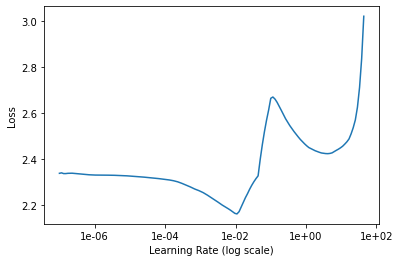

In [0]:
#lr_finder.plot()
#m1 amsgrad


fig, ax = plt.subplots(1, 1)
ax.set_ylabel('Loss')
ax.set_xlabel('Learning Rate (log scale)')
ax.set_xscale('log')
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
ax.plot(lr_finder.lrs[:-55], lr_finder.losses[:-55])

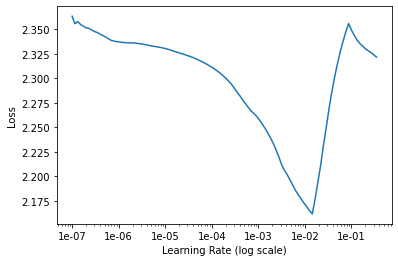

In [38]:
lr_finder1.plot(90)

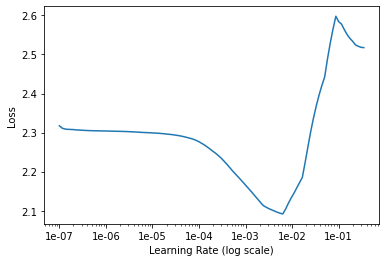

In [39]:
lr_finder3.plot(90)

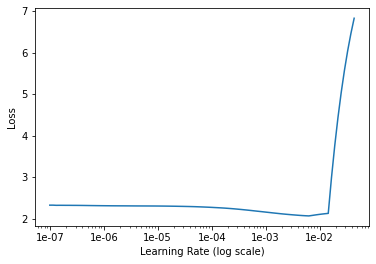

In [43]:
lr_finder6.plot(105)

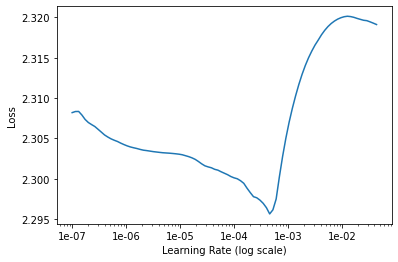

In [45]:
lr_finder7.plot(105)

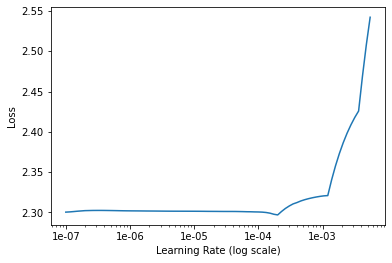

In [49]:
lr_finder8.plot(20)

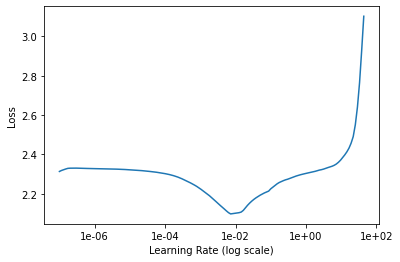

In [0]:
#lr_finder.plot()
#m1 adam

fig, ax = plt.subplots(1, 1)
ax.set_ylabel('Loss')
ax.set_xlabel('Learning Rate (log scale)')
ax.set_xscale('log')
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
ax.plot(lr_finder.lrs[:-55], lr_finder.losses[:-55])

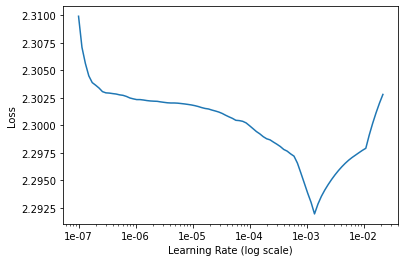

In [0]:

# m7
lr_finder.plot()

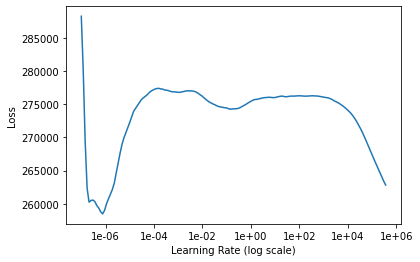

In [0]:
lr_finder.plot()

## sgd optimizer

In [0]:
lr_finder1s = LRFinder()
lr_finder2s = LRFinder()
lr_finder3s = LRFinder()
lr_finder6s = LRFinder()
lr_finder7s = LRFinder()
lr_finder8s = LRFinder()

In [41]:
#model = make_model(suffix, num_classes, input_shape)
model1s = make_model(1, num_classes, input_shape)
model3s = make_model(3, num_classes, input_shape)
model6s = make_model(6, num_classes, input_shape)
model7s = make_model(7, num_classes, input_shape)
model8s = make_model(8, num_classes, input_shape)

model1
model3
model 8


In [43]:
optname = 'Sgd'
learning_rate=.01

# with decay
xoptimizer = getOptimizer(optname, learning_rate, epochs) 

# w/o decay
xoptimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)


#model.compile(loss = 'categorical_crossentropy', optimizer=xoptimizer)
model1s.compile(loss = 'categorical_crossentropy', optimizer=xoptimizer)
model3s.compile(loss = 'categorical_crossentropy', optimizer=xoptimizer)
model6s.compile(loss = 'categorical_crossentropy', optimizer=xoptimizer)
model7s.compile(loss = 'categorical_crossentropy', optimizer=xoptimizer)
model8s.compile(loss = 'categorical_crossentropy', optimizer=xoptimizer)
print('done')



done


In [44]:
#history  = model.fit(train_generator, epochs=5, steps_per_epoch=100, verbose = 1,  callbacks=[lr_finder])
print('m1')
history1s  = model1s.fit(train_generator, epochs=5, steps_per_epoch=100, verbose = 1,  callbacks=[lr_finder1s])
print('m3')
history3s  = model3s.fit(train_generator, epochs=5, steps_per_epoch=100, verbose = 1,  callbacks=[lr_finder3s])
print('m6')
history6s  = model6s.fit(train_generator, epochs=5, steps_per_epoch=100, verbose = 1,  callbacks=[lr_finder6s])
print('m7')
history7s  = model7s.fit(train_generator, epochs=5, steps_per_epoch=100, verbose = 1,  callbacks=[lr_finder7s])
print('m8')
history8s  = model8s.fit(train_generator, epochs=5, steps_per_epoch=100, verbose = 1,  callbacks=[lr_finder8s])
print('m99')

m1
Epoch 1/5
100/100 [==============================] - 30s 302ms/step - loss: 2.3374
Epoch 2/5
100/100 [==============================] - 30s 300ms/step - loss: 2503.3638
m3
Epoch 1/5
100/100 [==============================] - 31s 309ms/step - loss: 2.2961
Epoch 2/5
100/100 [==============================] - 30s 300ms/step - loss: 656961679358305317708365824.0000
m6
Epoch 1/5
100/100 [==============================] - 30s 300ms/step - loss: 2.2983
Epoch 2/5
100/100 [==============================] - 30s 300ms/step - loss: nan
m7
Epoch 1/5
100/100 [==============================] - 31s 315ms/step - loss: 2.3023
Epoch 2/5
100/100 [==============================] - 31s 315ms/step - loss: nan
m8
Epoch 1/5
100/100 [==============================] - 31s 312ms/step - loss: 2.3022
Epoch 2/5
100/100 [==============================] - 31s 311ms/step - loss: 19319.0879
m99


# SGD Plots w/o Decay

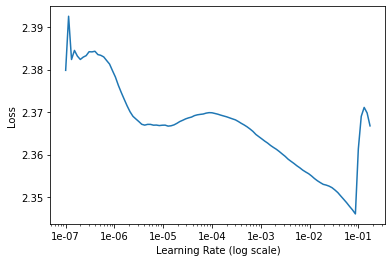

In [70]:
lr_finder1s.plot(95) # w/o decay


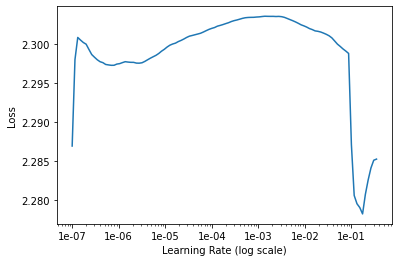

In [73]:
lr_finder3s.plot(90) # w/o decay

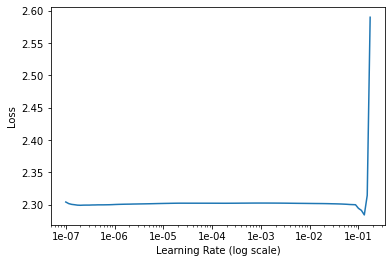

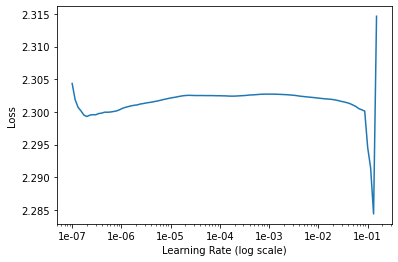

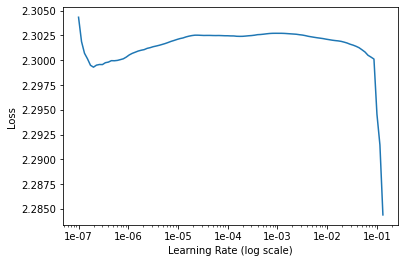

In [79]:
lr_finder6s.plot(95) # w/o decay
lr_finder6s.plot(96) # w/o decay

lr_finder6s.plot(97) # w/o decay


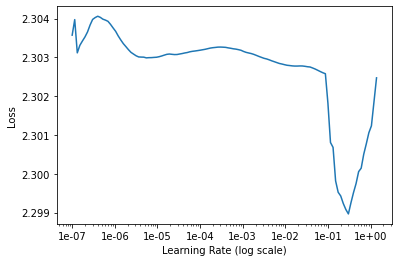

In [52]:
lr_finder7s.plot(80) # w/o decay

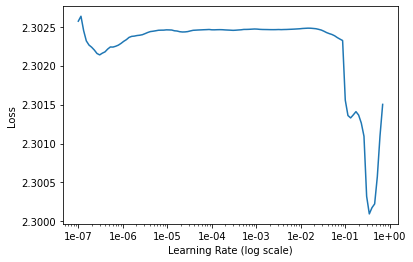

In [49]:
lr_finder8s.plot(85) # w/o deca

# SGD Plots with decay

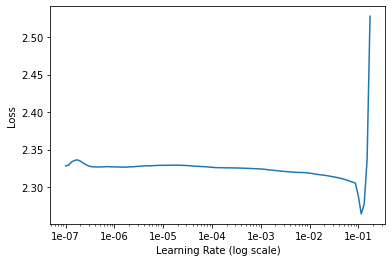

In [33]:
lr_finder1s.plot(95) # with decay

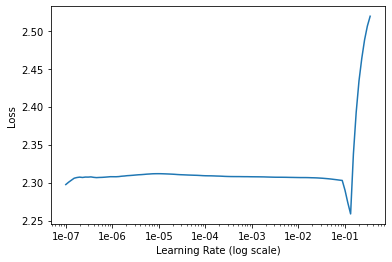

In [34]:
lr_finder3s.plot(90)  # with decay

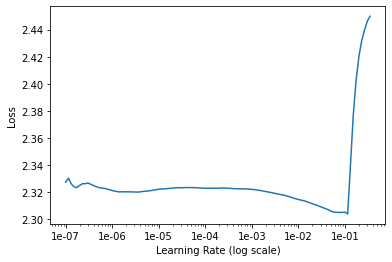

In [36]:
lr_finder6s.plot(90)  # with decay

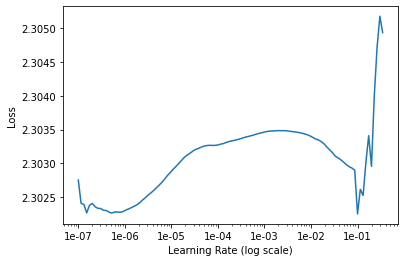

In [37]:
lr_finder7s.plot(90)  # with decay

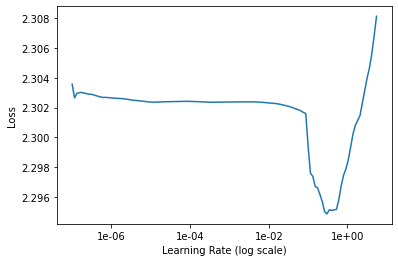

In [39]:
lr_finder8s.plot(70) # with decay

##RunMe

In [35]:
history_path = getHistoryPath()
print(history_path)

/content/gdrive/My Drive/Capstone2/history/


In [0]:
 
optnames = ['Adam', 'amsgrad', 'Sgd', 'sgdStep']
optnames = ['amsgrad']
learning_rates = [.001,0.0001]
suffixes = [1, 3, 6, 7, 8]
pixels = [150, 300]



learning_rates = [.0001]
suffixes = [1, 3, 6, 7, 8]
suffixes = [1, 3]
suffixes = [3]


pixels = [150]


print(optnames, learning_rates, suffixes, pixels)


['amsgrad'] [0.0001] [3] [150]


In [0]:
for optname in optnames:
    for learning_rate in learning_rates:
        for suffix in suffixes:
            for pixel in pixels:
                setPixels(pixel, pixel)
                lrFormatted = formatLR(learning_rate)




                # Label saved objects with model suffix and image size
                saveInfo = 'M' + str(suffix) + 'Pix' + str(pixel) + lrFormatted + optname
                print('SaveInfo: ', saveInfo)

SaveInfo:  M3Pix150LR4amsgrad


SaveInfo:  M3Pix150LR4amsgrad
Found 5055 images belonging to 10 classes.
Found 1092 images belonging to 10 classes.
Found 1095 images belonging to 10 classes.
model3
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPo

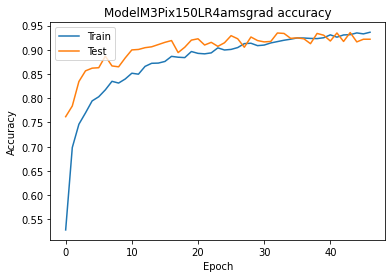

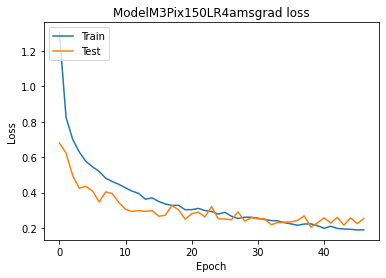

*** evaluating Model ***
34/34 [==============================] - 491s 14s/step - loss: 0.1966 - accuracy: 0.9292
[0.1965916007757187, 0.9292279481887817]
/content/gdrive/My Drive/Capstone2/history/evalM3Pix150LR4amsgrad
*** saving model  ***
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone2/saved_model/modelM3Pix150LR4amsgrad/assets


In [0]:
# =============================================================================
# Run Models
# =============================================================================

 
for optname in optnames:
    for learning_rate in learning_rates:
        for suffix in suffixes:
            for pixel in pixels:
                input_shape, target_size = setPixels(pixel, pixel)
                lrFormatted = formatLR(learning_rate)

 
                # Label saved objects with model suffix and image size
                saveInfo = 'M' + str(suffix) + 'Pix' + str(pixel) + lrFormatted + optname
                print('SaveInfo: ', saveInfo)

                # get details for parms

                train_generator, validation_generator = dataGenerators(target_size)

                test_generator = testDataGenerator(target_size)

                xoptimizer = getOptimizer(optname, learning_rate, epochs) 



                # Make Model

                model = make_model(suffix, num_classes, input_shape)
                model.summary()


                model, history = processModel(model, saveInfo, 250, 
                                            xoptimizer, 
                                            train_generator, validation_generator,
                                            batch_size,
                                            callbacks=callbacks)


                print('*** pickling history ***')
                pickleHist(history, history_path + 'history' + saveInfo)
                #pickleHist(history, history_path + 'historyLR1e4Epochs21d30Model' + str(suffix))


                print('*** plotting/saving history figures ***')
                # plot History
                #plotModelHistory(history, saveInfo)
                plotSaveModelHistory(history, saveInfo, history_path)




                print('*** evaluating Model ***')
                # Model Evaluation

                test_steps = int(test_generator.samples / batch_size)
                eval_output = model.evaluate(test_generator, steps=test_steps)         
                print(eval_output)



                # Save Evaluation information

                evalfile = history_path + 'eval' + saveInfo
                print(evalfile)
                #pickleEval(eval_output, history_path + 'eval' + str(suffix))
                pickleEval(eval_output, evalfile)



                print('*** saving model  ***')

                # Save the entire model as a SavedModel.

                savedmodeldir = '/content/gdrive/My Drive/Capstone2/saved_model/'

                #!mkdir -p savedmodeldir
                #!mkdir -p '/content/gdrive/My Drive/Capstone2/saved_model'
                modelpath =  savedmodeldir + 'model' + saveInfo
                model.save(modelpath)




In [0]:
 learning_rate

0.0001

# Results - from initial experimentation

![alt text](https://)




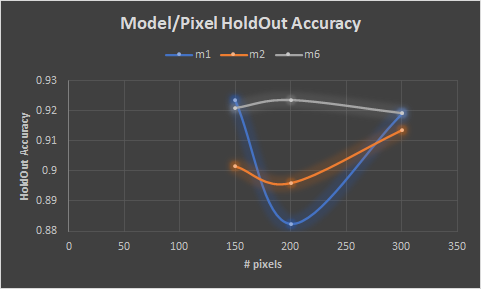